In [146]:
import sys
import datetime
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
import pyodbc
import sqlalchemy as db
from pandas.tseries.offsets import DateOffset
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

sys.path.append('C:/workarea/mylib/')
sys.path.append('C:/workarea/mylib/quant')
sys.path.append('C:/workarea/mylib/history')
sys.path.append('C:/workarea/merlin/')
import CORE_SQL as CS
from help_functions import most_frequent
from DbProcess import get_dataframe

import quant as q
import quant.helpers as hlp
from history import bt, history_tools as ht, history_db_tools as hdb
asys = q.AnalysisComponents()
coredb = q.CoreDB()
query = q.CoreQuery()
pfquery = q.portfolioQuery()
susratq = q.sustRatings()

import psycopg2
qrm = q.qrmDB()

import warnings
warnings.filterwarnings("ignore")

In [5]:
### MANAGE RETURN FILES 
loc1 = 'S:/Matrix/IA/IADE/0_Personal/1_Antonio/risk_return_contribution/pricing/'
t1 = dt.datetime.now()
#hdb.create_return_index(ret_type='net').to_csv(loc1 + 'MSCI_DAILY_TOTAL_NET_RETURN_INDEX.csv', sep=';')
#hdb.create_return_index(ret_type='gross').to_csv(loc1 + 'MSCI_DAILY_TOTAL_GROSS_RETURN_INDEX.csv', sep=';')
#hdb.create_return_index(msci=False, from_date='2018-12-28').to_csv(loc1 + 'SPI_DAILY_TOTAL_RETURN_INDEX.csv', sep=';')
hdb.extend_return_index(ret_type='net')
hdb.extend_return_index(ret_type='gross')
hdb.extend_return_index(msci=False)
hlp.timeit(t1)

from date: 2021-09-09
from date: 2021-09-09
from date: 2021-09-09
 runtime: 1 min 19 sec


In [2]:
#pp: get returns, trd engine, calc indicator, flag y, model, stat

In [3]:
#1 get returns
per = 'd'
t1 = dt.datetime.now()
dfperf = hdb.get_returns(ret_type='net', per=per)
lstdt = hdb.get_periodend_ed(per=per)#[-1:]
#dfcomp = hdb.get_composition_index_dates(dates=lstdt)
dfcomp = hdb.get_composition_dates(dates=lstdt)
dfcomp = hdb.apply_cols_basedon_col(dfcomp, cols=['ticker','ticker_region'], col='isin', datecol='Date')

dftrd = hdb.get_trdcomp_dates(dates=lstdt)
dftrd = hdb.apply_cols_basedon_col(dftrd, cols=['ticker'], col='isin', datecol='Date')
del dftrd['gics_sector_name']
del dftrd['gics_industry_group_name']
perf = dfperf.unstack().reset_index()
perf.columns = ['security_id','Date','tr']
dftrd = pd.merge(dftrd, perf, how='left', on =['Date','security_id'])

print(dfcomp.shape)
hlp.timeit(t1)
dfcomp.head(2)

(3619879, 23)
 runtime: 3 min 39 sec


,Date,security_id,fsym_id,sedol,isin,ticker,ticker_region,name,msci_country,msci_country_code,...,gics_sector_name,gics_industry_group_name,gics_industry_name,gics_sub_industry_name,msci_cap_size_cd,msci_mcap_ff_adj_usd,msci_iif,ison_mxwo,ison_mxef,ison_mxwosc
0,2019-11-25,B03GCV,FLD72S-R,B03GCV9,FR0004170017,LNA,LNA-FR,LNA SANTE,France,FR,...,Health Care,Health Care Equipment & Services,Health Care Providers & Services,Health Care Facilities,S,254.645837,NaN,False,False,True
1,2019-11-25,B03HDJ,FCJZ8L-R,B03HDJ7,GB00B03HDJ73,NaN,NaN,STOBART GROUP,United Kingdom,GB,...,Industrials,Transportation,Airlines,Airlines,S,484.171575,NaN,False,False,True


In [145]:
dftrd.head(2)

,Date,security_id,fsym_id,isin,ticker,name,msci_country_code,msci_cap_size_cd,msci_mcap_ff_adj_usd,fx_rate,currency,ret,popen,pclose,phigh,plow,volume,tr
0,2019-11-25,626377,W116T4-R,JP3551600004,6517,DENYO CO,JP,S,289.837575,108.94,JPY,3.25559,2116.0,2125.0,2169.0,2110.0,138.9,NaN
1,2019-11-25,626316,S2268J-R,JP3485600005,9793,DAISEKI CO,JP,S,1100.458968,108.94,JPY,1.86335,3290.0,3280.0,3300.0,3275.0,41.5,NaN


In [86]:
#2
dfbook = hdb.get_book(dfbook=dfbook, date='2021-05-15', id_val='AAPL',val=2000)
dfbook = hdb.get_book(dfbook=dfbook, date='2021-05-15', id_val='TSLA',val=3000)
dfcomp1 = hdb.get_comp_file(dfcomp, dfbook)
dfcomp1.head(2)

,Date,ticker,security_id,value
0,2021-05-03,AAPL,03783310,1000
0,2021-05-17,AAPL,03783310,3000


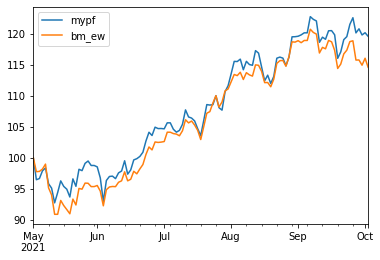

In [5]:
## plot and bm
basedate = str(sorted(dfcomp1.Date)[0])[:10]
tiklst = list(dfcomp1.ticker.drop_duplicates())
a = bt.backtest_pf(dfcomp1, basedate=basedate, dfperf=dfperf, wgting='value', baseval=100, pf_name='mypf', bbgid_field_name='security_id', nulls_2_zero=True)[0]
dfbm = dfcomp[(dfcomp.ticker.isin(tiklst)) & (dfcomp.Date>=basedate)]
b = bt.backtest_pf(dfbm, basedate=basedate, dfperf=dfperf, wgting='ew', baseval=100, pf_name='bm_ew', bbgid_field_name='security_id', nulls_2_zero=True)[0]
c = pd.concat([a, b], axis=1)
c.plot()

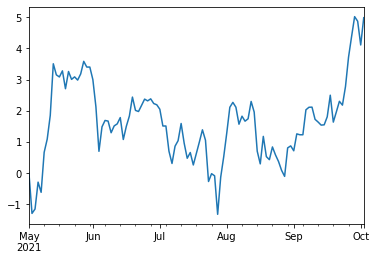

In [7]:
(c['mypf'] - c['bm_ew']).plot()

In [47]:
dfcomp[dfcomp.Date==dfcomp.Date.max()].groupby('msci_country_code').count()['isin'].sort_values(ascending=False).head(10)

msci_country_code
US    2480
JP    1201
CN     740
GB     350
CA     289
AU     254
IL     200
DE     176
SE     173
FR     147
Name: isin, dtype: int64

In [52]:
#t1 = dt.datetime.now()
#dftrd = hdb.get_trdcomp_dates(dates=lstdt)
#dftrd = hdb.apply_cols_basedon_col(dftrd, cols=['ticker'], col='isin', datecol='Date')
#del dftrd['gics_sector_name']
#del dftrd['gics_industry_group_name']
#perf = dfperf.unstack().reset_index()
#perf.columns = ['security_id','Date','tr']
#dftrd = pd.merge(dftrd, perf, how='left', on =['Date','security_id'])
#hlp.timeit(t1)

In [ ]:
def roll_book_fixedcash(dfbook, cashval, addcash=True):
    t1 = dt.datetime.now()
    if addcash:
        dfbook_1 = pd.DataFrame([['ticker','_CASH_', cashval]], columns=['id_type','id_val', 'value'])
    else:
        dfbook_1 = pd.DataFrame([], columns=['id_type','id_val', 'value'])
    rolledbook = pd.DataFrame([], columns=['Date','id_type','id_val', 'value'])
    i=0
    for d in dfbook.Date.drop_duplicates():
        dfbook_2 = pd.concat([dfbook[dfbook.Date==d][['id_type','id_val','value']], dfbook_1])
        dfbook_2 = dfbook_2.groupby(['id_val','id_type']).sum().reset_index()
        dfbook_2['value'] = dfbook_2['value'].apply(pd.to_numeric, errors='coerce')
        dfbook_2['Date'] = d
        dfbook_2 = dfbook_2.drop(dfbook_2[(dfbook_2['value'] <= 0)].index)
        dfbook_2.loc[dfbook_2.id_val=='_CASH_', 'value'] = cashval - dfbook_2[dfbook_2.id_val!='_CASH_'].value.sum()
        rolledbook = pd.concat([rolledbook, dfbook_2])
        dfbook_1 = dfbook_2
        #if i%50==0:
        #    print(i, 'of', len(dfbook.Date.drop_duplicates()))
        i+=1
    hlp.timeit(t1, 'roll_book')
    return rolledbook

In [188]:
#filter
t1 = dt.datetime.now()
idx1 = dftrd[(dftrd.tr.notnull()) & (dftrd.ticker.notnull())].index

create_compo = True

colist = ['US']
idaychg = 0.07 # ----------- min intraday change
sizedecile = [10,20,30,40,50] # ----------- size decle
turnover = 0.07 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 500 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 60


idx2 = dftrd[(dftrd.msci_country_code.isin(colist))].index
dftrd_ = dftrd.loc[idx1 & idx2]
dftrd_ = ht.get_bins(dftrd_, ntile_fld='msci_mcap_ff_adj_usd', nbins=10, group_fld=['Date'])
idx3 = dftrd_[dftrd_.bin.isin(sizedecile)].index

x = abs(dftrd_['phigh'] / dftrd_['plow'] - 1) > idaychg
idx4 = x[x==True].index

x = dftrd_.volume * dftrd_.pclose / dftrd_.fx_rate / dftrd_.msci_mcap_ff_adj_usd / 1000 > turnover
idx5 = x[x==True].index

idx6 = dftrd_[((dftrd_.pclose / dftrd_.fx_rate)< maxpr) & ((dftrd_.pclose / dftrd_.fx_rate)> minpr)].index

idx7 = dftrd_[(dftrd_.tr > lstretmin) & (dftrd_.tr < lstretmax)].index # --------- last return

t = dftrd_.loc[idx3 & idx4 & idx5 & idx6 & idx7]

t['t'] = 1
t['rank'] = t[['Date','ticker','security_id','t']].sort_values(['ticker','Date'], ascending=[1,1]).groupby('ticker')['t'].rank(method='first')
compo1 = t[t['rank']==1][['Date','ticker','security_id']].sort_values(['Date','ticker'], ascending=[1,1])

compo1['value'] = 1000
compo2 = compo1.copy()

compo2['Date'] = compo2['Date'].map(lambda x: x + DateOffset(days=hold))
compo2['value'] = -1000

compo = pd.concat([compo1, compo2]).sort_values('Date').reset_index(drop=True)
compo['id_type'] = 'ticker'
compo = compo.rename(columns={'ticker':'id_val'})
compo = compo[['Date','id_type','id_val','value']]

print('trds:', len(compo))
hlp.timeit(t1, 'srategy done')

#compo = hdb.get_comp_file(dfcomp, compo) #------- very slow
cashval = 41001
if create_compo:
    #compo = hdb.roll_book(compo)
    compo = roll_book_fixedcash(compo, cashval)
    print('max open:', compo.groupby('Date').value.sum().max(), ' - # stocks:', len(compo.id_val.drop_duplicates()), ' - at a time:', compo.groupby('Date').id_val.count().max())
    dfmrg = dfcomp.sort_values(['Date','security_id','ticker'], ascending=[0,1,1]).drop_duplicates(subset=['security_id','ticker'], keep='first')[['security_id','ticker']]
    compo = pd.merge(compo[['Date','id_val','value']].rename(columns={'id_val':'ticker'}), dfmrg, how='left', on=['ticker'])
    compo.loc[compo.ticker=='_CASH_', 'security_id'] = 'CASH'
hlp.timeit(t1, 'format done')

compo.head(2)

trds: 324
srategy done runtime: 5 sec
roll_book runtime: 2 sec
max open: 41001  - # stocks: 163  - at a time: 42
format done runtime: 12 sec


,Date,ticker,value,security_id
0,2019-11-26,MOV,1000,62458010
1,2019-11-26,_CASH_,40001,CASH


In [ ]:
## plot and bm
t1 = dt.datetime.now()

comptest = compo.copy()
basedate = str(sorted(comptest.Date)[0])[:10]
tiklst = list(comptest.ticker.drop_duplicates())
a = bt.backtest_pf(comptest, basedate=basedate, dfperf=dfperf, wgting='value', baseval=100, pf_name='mypf', bbgid_field_name='security_id', nulls_2_zero=True)[0]
dfbm = dfcomp[(dfcomp.ticker.isin(tiklst)) & (dfcomp.Date>=basedate)]
b = bt.backtest_pf(dfbm, basedate=basedate, dfperf=dfperf, wgting='ew', baseval=100, pf_name='bm_ew', bbgid_field_name='security_id', nulls_2_zero=True)[0]
c = pd.concat([a, b], axis=1)

hlp.timeit(t1)
c.plot()
plt.show()
print('delta')
(c['mypf'] - c['bm_ew']).plot()

 runtime: 38 sec


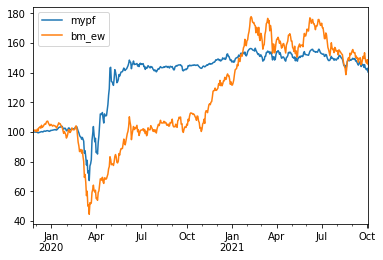

delta


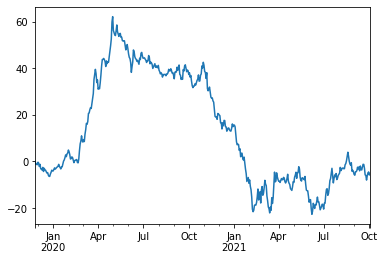

In [189]:
#fixed cash 10K
colist = ['US']
idaychg = 0.07 # ----------- min intraday change
sizedecile = [10,20,30,40,50] # ----------- size decle
turnover = 0.07 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 500 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 60

 runtime: 29 sec


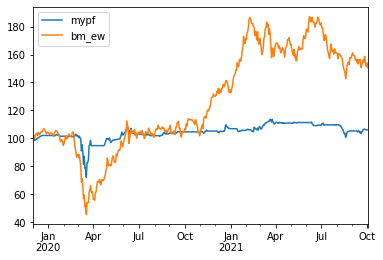

delta


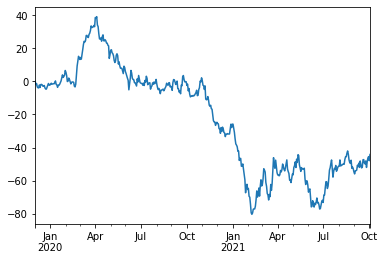

In [178]:
#fixed cash 10K
colist = ['US']
idaychg = 0.1 # ----------- min intraday change
sizedecile = [10] # ----------- size decle
turnover = 0.1 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 200 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 19 sec


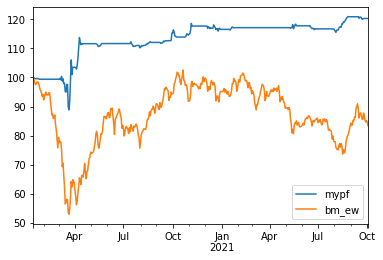

delta


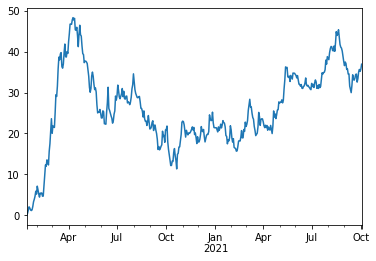

In [170]:
#fixed cash 10K
colist = ['JP']
idaychg = 0.05 # ----------- min intraday change
sizedecile = [10,20] # ----------- size quartile
turnover = 0.05 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 200 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 19 sec


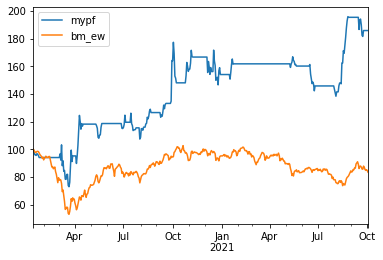

delta


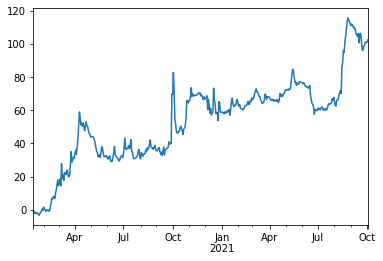

In [151]:
#changing cash min 1
colist = ['JP']
idaychg = 0.05 # ----------- min intraday change
sizedecile = [10,20] # ----------- size quartile
turnover = 0.05 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 200 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 28 sec


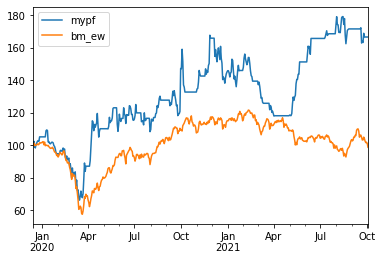

delta


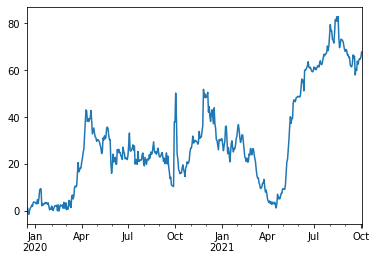

In [135]:
#JP
idaychg = 0.05 # ----------- min intraday change
sizedecile = [10,20] # ----------- size quartile
turnover = 0.05 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 20000 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.05 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 31 sec


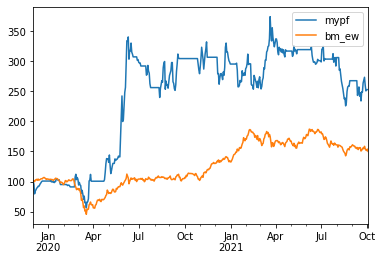

delta


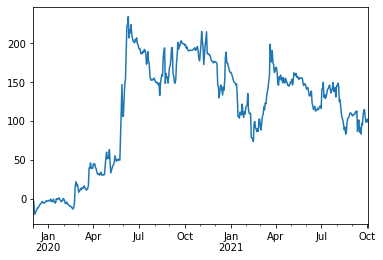

In [127]:
##US
idaychg = 0.1 # ----------- min intraday change
sizedecile = 10 # ----------- size quartile
turnover = 0.1 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 200 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 31 sec


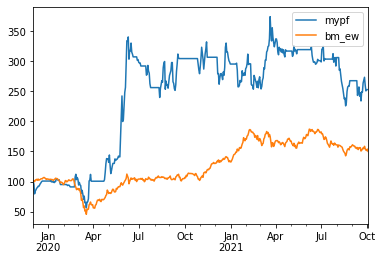

delta


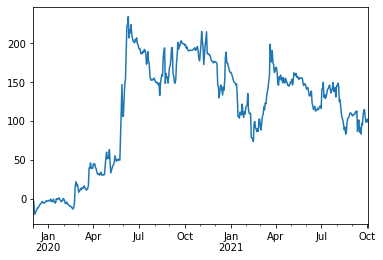

In [125]:
idaychg = 0.1 # ----------- min intraday change
sizedecile = 10 # ----------- size quartile
turnover = 0.1 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 500 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 23 sec


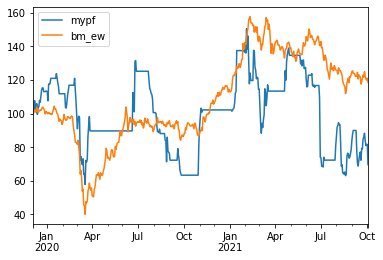

delta


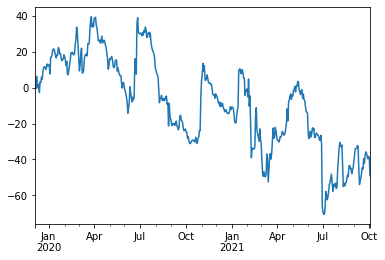

In [123]:
idaychg = 0.1 # ----------- min intraday change
sizedecile = 10 # ----------- size quartile
turnover = 0.1 # ---------min ADTV / MCAP
minpr = 0.5 # --------- min price 
maxpr = 500 # --------- max price
lstretmin = -0.5 # --------- min last return
lstretmax = -0.25 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 30 sec


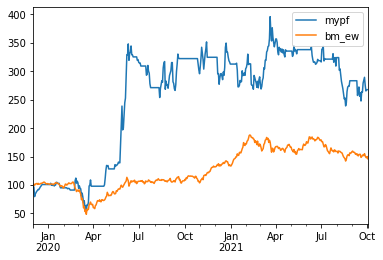

delta


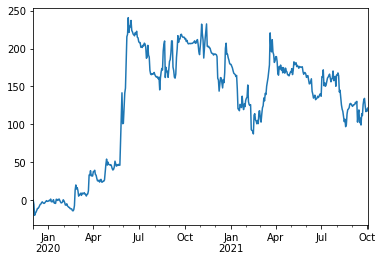

In [119]:
idaychg = 0.1 # ----------- min intraday change
sizedecile = 10 # ----------- size quartile
turnover = 0.1 # ---------min ADTV / MCAP
minpr = 2 # --------- min price 
maxpr = 200 # --------- max price
lstretmin = -0.3 # --------- min last return
lstretmax = -0.1 # --------- max last return
occurence = 1 # --------- time it happens
hold = 10

 runtime: 31 sec


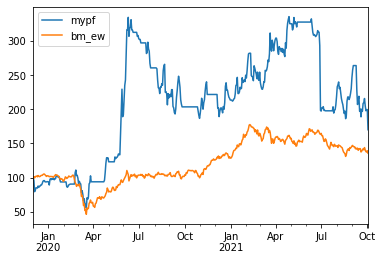

delta


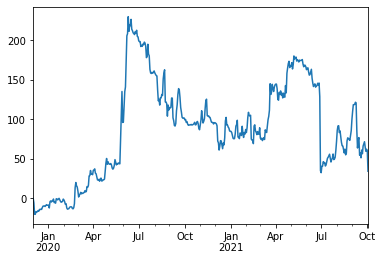

In [68]:
idaychg = 0.1 # ----------- min intraday change
sizedecile = 10 # ----------- size quartile
turnover = 0.1 # ---------min ADTV / MCAP
minpr = 2 # --------- min price 
maxpr = 200 # --------- max price
lstretmin = -0.5 # --------- min last return
lstretmax = -0.1 # --------- max last return
firstime = 1 # --------- use first (1) or last (0) time

 runtime: 31 sec


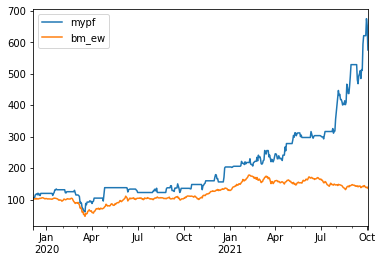

delta


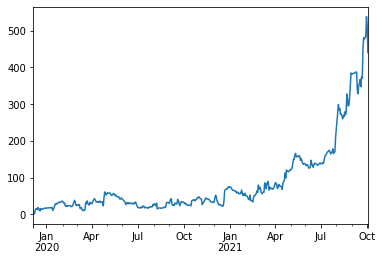

In [63]:
idaychg = 0.1 # ----------- min intraday change
sizedecile = 10 # ----------- size quartile
turnover = 0.1 # ---------min ADTV / MCAP
minpr = 2 # --------- min price 
maxpr = 200 # --------- max price
lstretmin = -0.5 # --------- min last return
lstretmax = -0.1 # --------- max last return
firstime = 0 # --------- use first (1) or last (0) time